In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

### About dataset

*The dataset is historic Binance data about "BTCUSDT" token price changes during 26-27 July 2023.*

In [2]:
# convert func of unix time data to datetime object
def unix_time_convert(seconds):
    return pd.Timestamp(datetime.utcfromtimestamp(seconds // 1000))

In [3]:
# upload data
names = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_volume", "count", "take_by_volume", "take_buy_quote_volume", "ignore"]
df = pd.read_csv("BTCUSDT-1s-2023-07-26/BTCUSDT-1s-2023-07-26.csv", names=names).iloc[:, :7]
df.head()

,open_time,open,high,low,close,volume,close_time
0,1690329600000,29228.91,29228.92,29228.91,29228.91,0.02030,1690329600999
1,1690329601000,29228.92,29228.92,29228.91,29228.91,0.07655,1690329601999
2,1690329602000,29228.92,29228.92,29228.91,29228.92,0.10322,1690329602999
3,1690329603000,29228.91,29228.91,29228.91,29228.91,0.00476,1690329603999
4,1690329604000,29228.91,29228.92,29228.91,29228.91,0.02008,1690329604999


In [4]:
# get the start coin price
start_price = df.loc[0, "close"]

In [5]:
# convert unix time data
df[["open_time", "close_time"]] = df[["open_time", "close_time"]].applymap(unix_time_convert)
df.head()

,open_time,open,high,low,close,volume,close_time
0,2023-07-26 00:00:00,29228.91,29228.92,29228.91,29228.91,0.02030,2023-07-26 00:00:00
1,2023-07-26 00:00:01,29228.92,29228.92,29228.91,29228.91,0.07655,2023-07-26 00:00:01
2,2023-07-26 00:00:02,29228.92,29228.92,29228.91,29228.92,0.10322,2023-07-26 00:00:02
3,2023-07-26 00:00:03,29228.91,29228.91,29228.91,29228.91,0.00476,2023-07-26 00:00:03
4,2023-07-26 00:00:04,29228.91,29228.92,29228.91,29228.91,0.02008,2023-07-26 00:00:04


In [6]:
# set time series as index
df.set_index("open_time", inplace=True)

# Strategy

*The chosen strategy for the trading hypothesis is a simple concept of buying when the price goes down and selling vice versa. The proposals stated below are the author's ideas about the profitable algorithm of an order setting for short positions that have not been tested in real-world stock markets and can be wrong.*

### Proposal 1: Set orders appropriately to the current estimation of future price fluctuations in a wider range.

*There is no matter how the price decreases if we "play" on short price fluctuations. So, it is necessary to estimate price values in real time. Also, price fluctuations during one second are minor, and we can't properly evaluate him. The author chose the five-minute interval for further work.*

In [7]:
# Find fluctuations from the initial price.

<AxesSubplot:xlabel='open_time'>

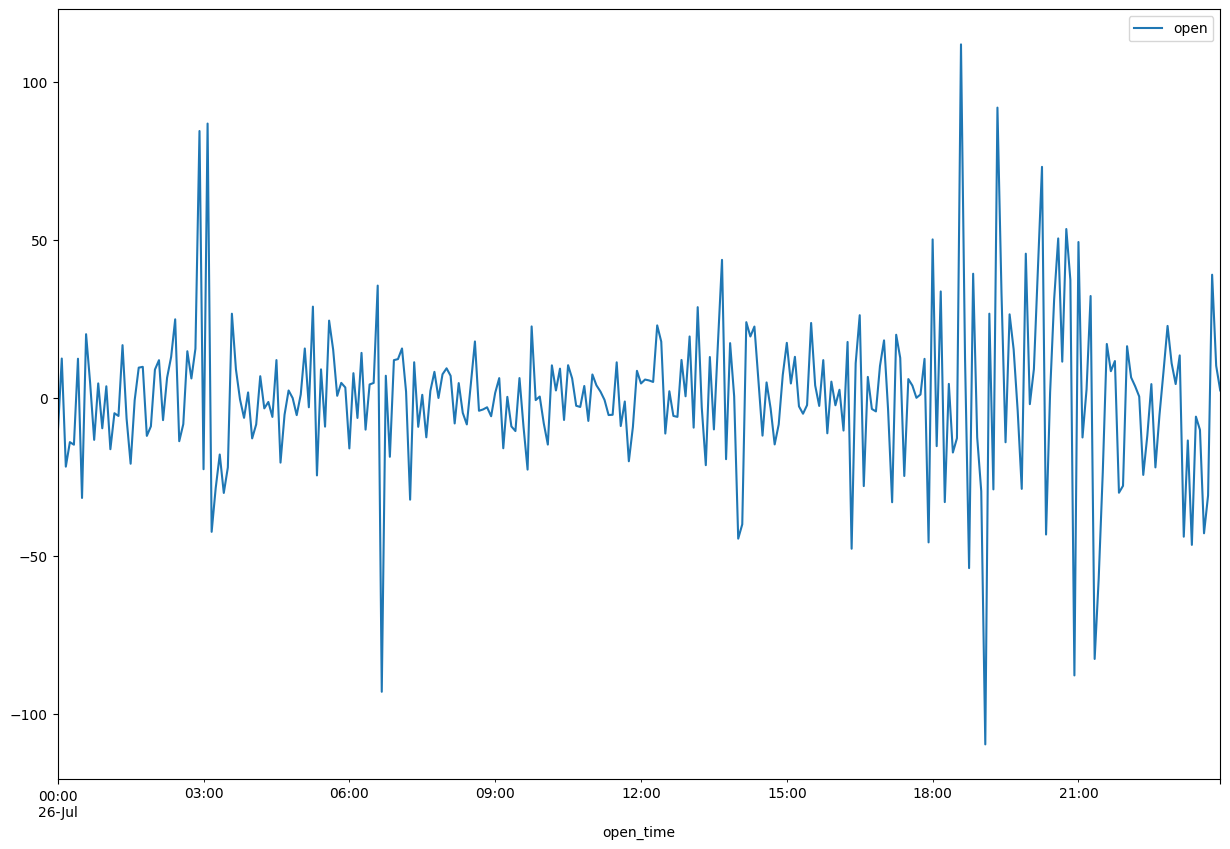

In [8]:
# get price opening values
price_change = df["open"]
# find sequential price change
price_change -= price_change.shift(1)
# find fluctuations during the five-minute interval
fm_diff = price_change.resample("5T").sum().to_frame()
fm_diff.plot(kind="line", figsize=(15, 10))

In [9]:
# find intervals of increase and decrease
fm_diff["delta"] = fm_diff - fm_diff.shift(1)
# find price delta over time
fm_diff["up-down"] = np.sign(fm_diff["delta"]).values
# drop price changes during first five minutes for simplicity
fm_diff.drop(index=fm_diff.index[0], inplace=True)
fm_diff.head()

,open,delta,up-down
open_time,,,
2023-07-26 00:05:00,12.50,24.18,1.0
2023-07-26 00:10:00,-21.74,-34.24,-1.0
2023-07-26 00:15:00,-13.98,7.76,1.0
2023-07-26 00:20:00,-14.79,-0.81,-1.0
2023-07-26 00:25:00,12.44,27.23,1.0


### Proposal 2: Simplify intervals of increase and decrease by removing consecutive.

*It will simplify the data wrangling process and price fluctuations estimation despite probably less profitable output.*

In [10]:
# the chosen time delta
timeDelta = pd.Timedelta(minutes=5)

In [ ]:
# find rows with consecutive intervals of increase and decrease
con_int = fm_diff[fm_diff["up-down"].shift(-1) == fm_diff["up-down"]]
# union consecutive intervals
for index in range(len(con_int)):
    fm_diff.loc[con_int[index:index+1].index + timeDelta, "delta"] += con_int[index:index+1]["delta"].iloc[0]
# drop and replace rows with consecutive intervals
fm_diff.drop(con_int.index, inplace=True)
# add time delta column between the open price for further wrangling
fm_diff["time_delta"] = fm_diff.index - pd.Series(fm_diff.index).shift(1).values
fm_diff["time_delta"].fillna(timeDelta, inplace=True)
# update delta column regard to changes
fm_diff["delta"] = fm_diff["open"] - fm_diff["open"].shift(1)

 ### Proposal 3: Set the buy market orders exponentially, the sell market orders linearly and the fixed number of orders by interval.

*The main idea is that we can keep pace with the buy-sell process and have more successful sell orders. As the exponential function dramatically increases than the linear function, many buy order setups will have the highest price deviation. As we roughly estimate price fluctuations over time, the optimal sell orders setup is linear for balanced profit. The chosen functions are y=2^x and y=kx+b because of common usage. Also, fixed order amounts are set per interval for simplification of evaluation - 10. Read more in the limitations section about the above choices.*

In [ ]:
# make up orders setups table

In [ ]:
def orders_setup(rows, OA, _timeDelta):
    """Return orders setting up data frame"""
    # orders placing coefficients for interval of increase
    up_timedelta = np.array(list(1 / OA * delta
                                 for delta in range(1, OA+1)))
    # orders placing coefficients for interval of decrease
    down_timedelta = np.array(list(1 / 2**delta
                                   for delta in range(1, OA+1))).cumsum()
    up_down_dict = {1: up_timedelta, -1:  down_timedelta}
    # orders data frame
    orders_df = pd.DataFrame()
    for ind in range(len(rows)):
        # orders data frame by interval
        orders = pd.DataFrame()
        for _ in range(OA):
            orders = pd.concat([orders, rows[ind:ind+1]])
        # add timestamp column
        orders["timestamp"] = up_down_dict[rows[ind:ind+1].iloc[0, -2]]
        # find price for setups order
        orders["open"] -= orders["delta"] * (1 - orders["timestamp"])
        # change orders setups time markers 
        orders.index += orders["time_delta"].iloc[0] * (orders["timestamp"] - 1)
        # add partial orders setups to overall result
        orders_df = pd.concat([orders_df, orders])
    return orders_df

# amount of orders by interval
ord_amount = 10
# the orders table
orders_ = orders_setup(fm_diff, ord_amount, timeDelta)

In [ ]:
# plot orders setup
figure1, axes1 = plt.subplots(2, 1, figsize=(20, 20))
ax1, ax2 = axes1[0], axes1[1]
# all settings
ax1.plot(fm_diff["open"], "k", linewidth="2", label="price")
ax1.plot(orders_["open"], "r.", markersize="8", label="orders")
ax1.legend()
# lower scale plot
ax2.plot(fm_diff["open"][:"2023-07-26 1H"], "k", linewidth="3", label="price")
ax2.plot(orders_["open"][:"2023-07-26 1H"], "r.", markersize="12", label="orders")
ax2.legend()

# Summarization

*Count successful orders, revenue over the period, and overall revenue.*

In [ ]:
# profit and losses over time
pl = pd.Series(orders_[orders_["up-down"] == 1]["open"].values - \
          orders_[orders_["up-down"] == -1]["open"].values)

# profit and losses by orders setups time series
ts_results = orders_[orders_["up-down"] == 1].index
pl.index = ts_results

# successful and failed orders
s_orders, f_orders = (pl >= 0).sum(), (pl < 0).sum()
sf = pd.DataFrame([s_orders, f_orders], index=["Successful", "Failed"], columns=["Orders"]).T

# get summary profit and losses regarding the initial coin price
profit, losses = pl[pl >= 0].sum(), abs(pl[pl < 0].sum())
pl_df = pd.DataFrame([profit, losses], index=["Profit", "Loss"], columns=["Money"]).T

In [ ]:
# plot statistics
figure2, axes2 = plt.subplots(figsize=(15, 10))

orders_ax = plt.subplot(221)
sf.plot(ax=orders_ax, kind="bar", color=["green", "red"], rot=0)

profit_ax = plt.subplot(222)
pl_df.plot(ax=profit_ax, kind="bar", color=["#023020", "#8B0000"], rot=0)

time_change = plt.subplot(212)
pl.plot(ax=time_change, kind="line", color="black")


In [ ]:
# overall percentage profit
net_profit = profit - losses
net_profit / start_price * 100

# Limitations

*There was not considered:*
-  the optimal period for setting orders
-  concrete marker setting - only setting by general functions was proposed
-  no explored efficiency of functions regard to others possible
</br>

*Overall, the simpleness of the hypothesis by many factors.*

# Conclusion

*There was a proposed simple hypothesis for optimal stock trading that works based on a fundamental trading strategy. The proposals produce a 53.6% percentage of net revenue and higher successful output. Aspects in the limitations section need further exploration.*